# Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import matplotlib.gridspec as gridspec

from collections import Counter
from keras.backend import clear_session
from keras import layers, models, optimizers
from tensorflow.keras import layers as tfl
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import activations, metrics, utils
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec


# Preparing Dataset

Mounted at /content/drive


In [3]:
import zipfile
import os

zip_train = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip','r')
zip_train.extractall('/tmp')
zip_train.close()

In [4]:
BASE_DIR = '../FineTune/Dataset/'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 files belonging to 1 classes.


In [18]:
directory = '../FineTune/Dataset/'
BATCH_SIZE = 32
EPOCHS = 20

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0 / 255.0
)

train_dataset = train_datagen.flow_from_directory(
    directory + "seg_train/seg_train",
    batch_size=BATCH_SIZE,
    target_size=(224, 224),
    class_mode='sparse',
    subset='training'
)

validation_dataset = train_datagen.flow_from_directory(
    directory + "seg_train/seg_train",
    batch_size=BATCH_SIZE,
    target_size=(224, 224),
    class_mode='sparse',
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory + "seg_test/seg_test",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)
predict_dataset = image_dataset_from_directory(
    directory="/tmp/seg_pred/seg_pred",
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=False,
    label_mode=None
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 files belonging to 1 classes.


#Augmenting Images

In [19]:
def aug_data():
    directory = "/tmp/"
    TRAIN_DATAGEN = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    VALIDATION_DATAGEN = ImageDataGenerator(rescale=1./255)

    train_dataset = TRAIN_DATAGEN.flow_from_directory(
        directory + "seg_train/seg_train",
        batch_size=BATCH_SIZE,
        target_size=(224, 224),

        class_mode='sparse'
    )

    validation_dataset = VALIDATION_DATAGEN.flow_from_directory(
        directory + "seg_test/seg_test",
        batch_size=BATCH_SIZE,
        target_size=(224, 224),
        class_mode='sparse',

    )

    return train_dataset, validation_dataset

In [20]:
aug_train_dataset, aug_vali_dataset = aug_data()

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Data exploration

Total number of each label in each class in traing and test dataset

In [21]:
print("TRAINING DATA:")
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

print("\n\nTEST DATA:")
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

TRAINING DATA:
glacier : 2404 files
forest : 2271 files
mountain : 2512 files
buildings : 2191 files
street : 2382 files
sea : 2274 files


TEST DATA:
glacier : 553 files
forest : 474 files
mountain : 525 files
buildings : 437 files
street : 501 files
sea : 510 files


In [22]:
class_indices = train_dataset.class_indices
class_names = {v: k for k, v in class_indices.items()}
images, labels = next(train_dataset)
print(class_names)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


 **Plotting the count of labels per class**

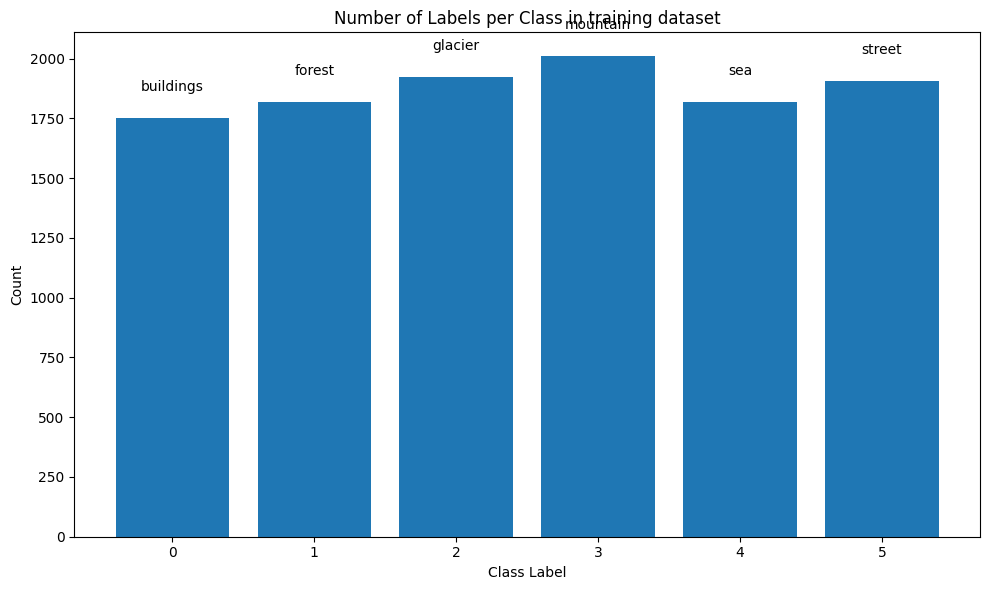

In [23]:
label_counts = Counter(train_dataset.labels)

plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Number of Labels per Class in training dataset')

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05 * max(label_counts.values()), class_names[i], ha='center', va='bottom')

plt.tight_layout()
plt.show()


Sample images from dataset

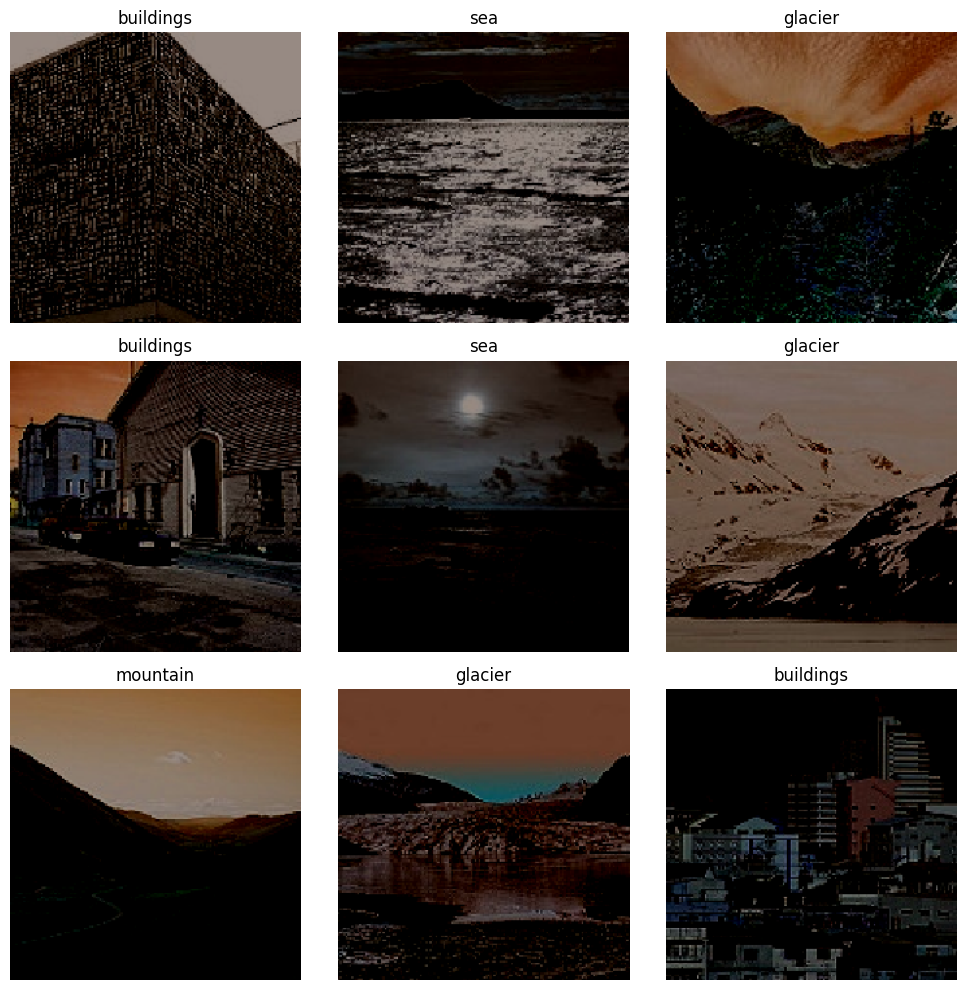

In [24]:
plt.figure(figsize=(10, 10))

for i in range(9):
    # Displaying the first 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Convert images to uint8 for display
    plt.title(class_names[int(labels[i])])  # Accessing class names using class_indices
    plt.axis("off")

plt.tight_layout()
plt.show()


Samples of augmented images from dataset

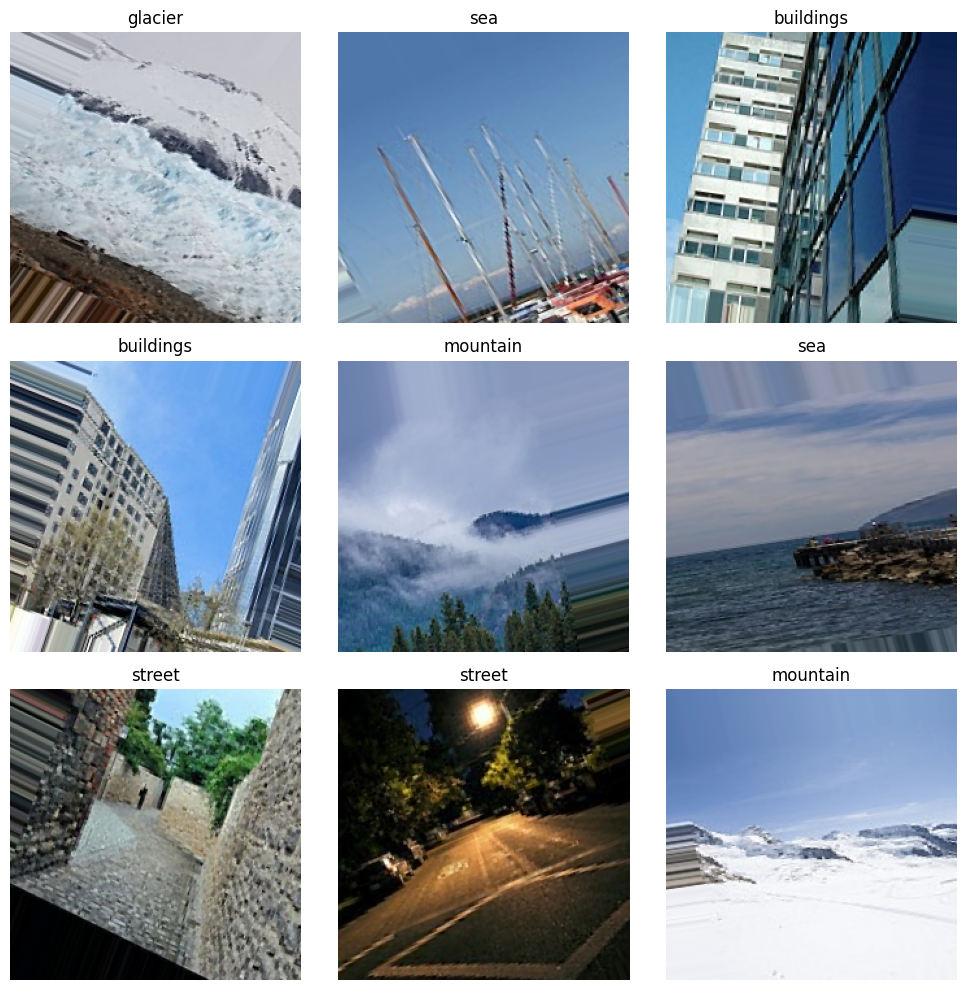

In [25]:
images, labels = next(aug_train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
#Function for plotting results of trained model
def plot_acc_loss(history):

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

# Create and train a simple model

In [31]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [32]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [33]:
history_simple = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset)

Epoch 1/10
351/351 [==============================] - 46s 115ms/step - loss: 1.2191 - accuracy: 0.5209 - val_loss: 1.0243 - val_accuracy: 0.5888
Epoch 2/10
351/351 [==============================] - 34s 97ms/step - loss: 0.9463 - accuracy: 0.6438 - val_loss: 0.7419 - val_accuracy: 0.7243
Epoch 3/10
351/351 [==============================] - 37s 104ms/step - loss: 0.7985 - accuracy: 0.7086 - val_loss: 0.6919 - val_accuracy: 0.7457
Epoch 4/10
351/351 [==============================] - 46s 131ms/step - loss: 0.7015 - accuracy: 0.7549 - val_loss: 0.5783 - val_accuracy: 0.8010
Epoch 5/10
351/351 [==============================] - 41s 116ms/step - loss: 0.6306 - accuracy: 0.7759 - val_loss: 0.6026 - val_accuracy: 0.7743
Epoch 6/10
351/351 [==============================] - 35s 101ms/step - loss: 0.5816 - accuracy: 0.7982 - val_loss: 0.5502 - val_accuracy: 0.8017
Epoch 7/10
351/351 [==============================] - 34s 98ms/step - loss: 0.5345 - accuracy: 0.8133 - val_loss: 0.4837 - val_accu

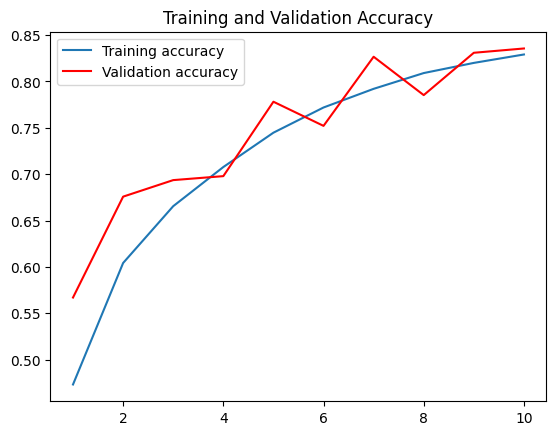

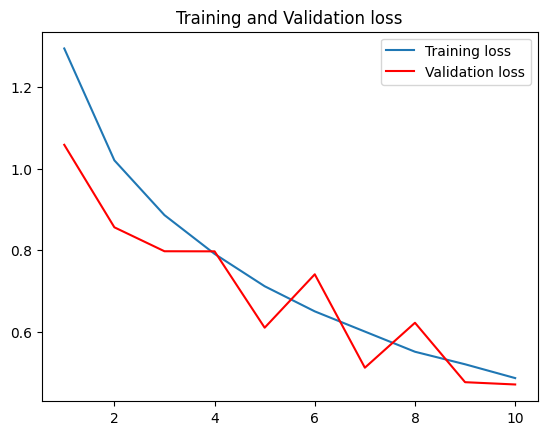

Average Validation loss:  0.6940935343503952
Average Validation accuracy: 74.43 %


In [ ]:
plot_acc_loss(history_simple)

# Fine tuning using VGG16 pretrained network

In [ ]:
conv_base = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = (224,224,3)
                 )

In [ ]:
set_trainable = False
for layer in conv_base.layers:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy', # labels are in integer form
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
history = model.fit_generator(
                                train_dataset,
                                steps_per_epoch = train_dataset.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_dataset,
                                validation_steps = validation_dataset.samples // BATCH_SIZE,
                             )

Epoch 1/20


<ipython-input-87-f15a5908c4c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


350/350 [==============================] - 71s 180ms/step - loss: 1.1951 - accuracy: 0.8461 - val_loss: 0.3412 - val_accuracy: 0.9048
Epoch 2/20
350/350 [==============================] - 61s 174ms/step - loss: 0.2716 - accuracy: 0.9217 - val_loss: 0.3584 - val_accuracy: 0.9106
Epoch 3/20
350/350 [==============================] - 72s 206ms/step - loss: 0.2091 - accuracy: 0.9412 - val_loss: 0.3922 - val_accuracy: 0.9134
Epoch 4/20
350/350 [==============================] - 72s 205ms/step - loss: 0.1973 - accuracy: 0.9456 - val_loss: 0.3933 - val_accuracy: 0.9127
Epoch 5/20
350/350 [==============================] - 70s 200ms/step - loss: 0.1588 - accuracy: 0.9593 - val_loss: 0.3920 - val_accuracy: 0.9170
Epoch 6/20
350/350 [==============================] - 70s 199ms/step - loss: 0.1354 - accuracy: 0.9635 - val_loss: 0.4187 - val_accuracy: 0.9113
Epoch 7/20
350/350 [==============================] - 62s 176ms/step - loss: 0.1288 - accuracy: 0.9664 - val_loss: 0.4186 - val_accuracy: 0.9

In [ ]:
plot_acc_loss(history)

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_dataset, steps=test_dataset.samples // BATCH_SIZE)
print(f"Test Accuracy before fine tuning: {test_acc*100:.2f} %")

<ipython-input-90-f9b5a2dcc580>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_dataset, steps=test_dataset.samples // BATCH_SIZE)


Test Accuracy before fine tuning: 92.00 %


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(254, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 254)               6372606   
                                                                 
 dropout_3 (Dropout)         (None, 254)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 1530      
                                                                 
Total params: 21088824 (80.45 MB)
Trainable params: 13453560 (51.32 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])


In [ ]:
history3 = model.fit(train_dataset,
                     epochs = EPOCHS,
                     validation_data = validation_dataset,
                     )
clear_session()

In [ ]:
aug_train_dataset, aug_vali_dataset = aug_data()

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
history3 = model.fit(aug_train_dataset,
                     epochs = EPOCHS,
                     validation_data = aug_vali_dataset
                     )

Epoch 1/20
439/439 [==============================] - 237s 537ms/step - loss: 0.5286 - accuracy: 0.8026 - val_loss: 0.3402 - val_accuracy: 0.8767
Epoch 2/20
439/439 [==============================] - 224s 511ms/step - loss: 0.3626 - accuracy: 0.8703 - val_loss: 0.3403 - val_accuracy: 0.8757
Epoch 3/20
439/439 [==============================] - 225s 514ms/step - loss: 0.3250 - accuracy: 0.8858 - val_loss: 0.3179 - val_accuracy: 0.8890
Epoch 4/20
439/439 [==============================] - 218s 497ms/step - loss: 0.2885 - accuracy: 0.8967 - val_loss: 0.2497 - val_accuracy: 0.9077
Epoch 5/20
439/439 [==============================] - 225s 512ms/step - loss: 0.2641 - accuracy: 0.9054 - val_loss: 0.2579 - val_accuracy: 0.9107
Epoch 6/20
439/439 [==============================] - 221s 504ms/step - loss: 0.2412 - accuracy: 0.9158 - val_loss: 0.2632 - val_accuracy: 0.9107
Epoch 7/20
439/439 [==============================] - 221s 503ms/step - loss: 0.2347 - accuracy: 0.9140 - val_loss: 0.2384 -

In [35]:
model.evaluate(test_dataset,steps=test_dataset.samples, verbose=1)

  94/3000 [..............................] - ETA: 3:22 - loss: 0.4453 - accuracy: 0.8577

3000/3000 [==============================] - 7s 2ms/step - loss: 0.4453 - accuracy: 0.8577


[0.44530317187309265, 0.8576666712760925]

In [36]:
batch_images, batch_labels = next(test_dataset)
pred_images = np.array(batch_images)
pred_images = pred_images.shape
print(f"Shape of one sample: {pred_images}")


Shape of one sample: (32, 224, 224, 3)
2.0


# Predicition on unseen data to trained model

In [37]:
predictions = model.predict(predict_dataset)


229/229 [==============================] - 8s 34ms/step


In [38]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}

    return labels[class_code]

1/1 [==============================] - 0s 33ms/step


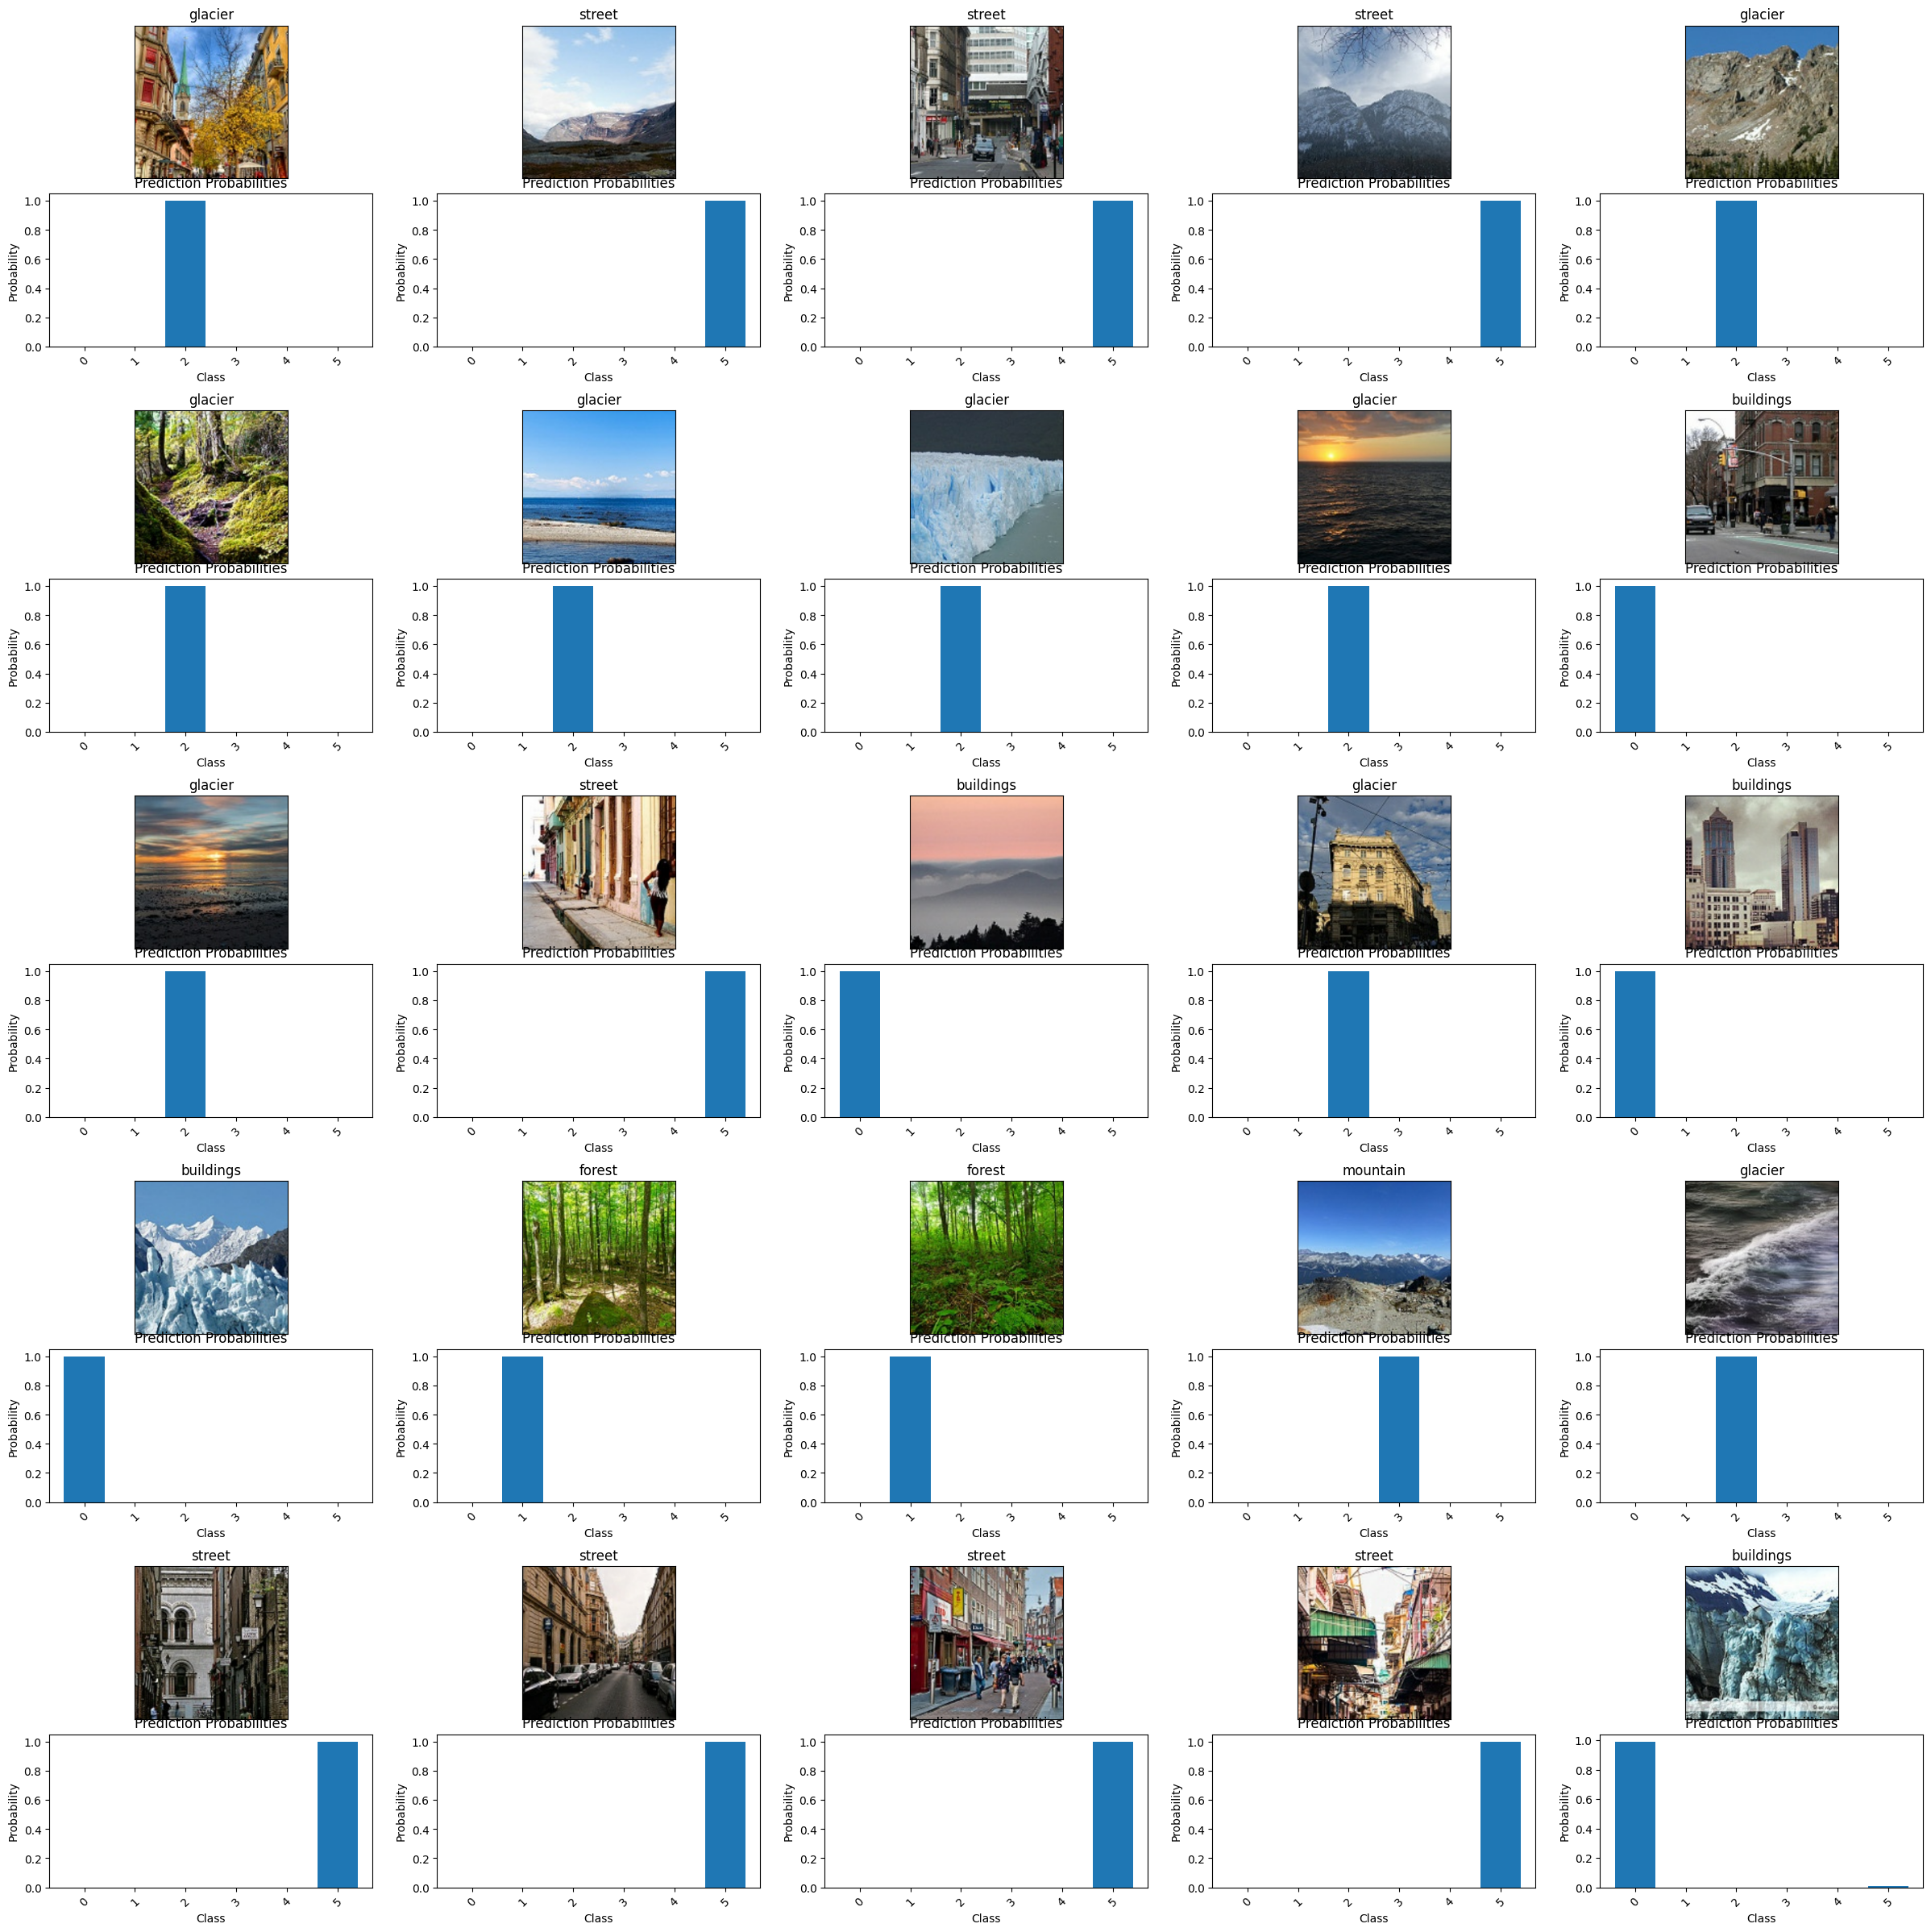

In [39]:



fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)


num_images = 25  # Number of images to predict and plot

for i, pred_images in enumerate(predict_dataset):
    if i >= num_images:
        break

    pred_prob = model.predict(pred_images).reshape(-1, 6)
    pred_classes = np.argmax(pred_prob, axis=1)  # Get predicted classes

    for j in range(pred_images.shape[0]):
        if (i * pred_images.shape[0]) + j >= num_images:
            break

        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[(i * pred_images.shape[0]) + j], wspace=0.1, hspace=0.1)

        # Display the image without normalization
        ax = plt.Subplot(fig, inner[0])
        ax.imshow(pred_images[j].numpy().astype(np.uint8))
        ax.set_title(get_classlabel(pred_classes[j]))
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

        # Display the prediction probabilities
        ax = plt.Subplot(fig, inner[1])
        ax.bar(range(6), pred_prob[j])
        ax.set_title("Prediction Probabilities")
        ax.set_xlabel("Class")
        ax.set_ylabel("Probability")
        ax.set_xticks(range(6))
        ax.tick_params(axis='x', rotation=45)
        fig.add_subplot(ax)

plt.show()